In [2]:
import tifffile as tiff
import sys
sys.path.insert(0, '../')
import cv2

from shapely.wkt import loads as wkt_loads
import matplotlib.pyplot as plt
import pandas as pd
%pylab inline

import json
from shapely.geometry import mapping, shape
import geojson
import glob

import numpy as np
import tifffile as tiff

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read in gridsizes

In [123]:
grid_sizes_df = pd.read_csv("../data/grid_sizes.csv", names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)

#SF = pd.read_csv('/content/sample_submission.csv')
grid_sizes_df = grid_sizes_df.rename( columns={'Unnamed: 0':'ImageId'}) #rename 'ImageId'

# Read in geojson

In [72]:

path_to_file = "../data/train_geojson_v3/6010_1_2/001_MM_L5_MISC_SMALL_STRUCTURE.geojson"
with open(path_to_file) as f:
    gj = geojson.load(f)

In [76]:
gj['features'][0]

{"geometry": {"coordinates": [[[0.00896, -0.007128], [0.008952, -0.007108], [0.008935, -0.007109], [0.008937, -0.007125], [0.008933, -0.007125], [0.008931, -0.007107], [0.008955, -0.007106], [0.008965, -0.007126], [0.00896, -0.007128]]], "type": "Polygon"}, "properties": {"ACAD_LAYER": "001_MM_L5_MISC_SMALL_STRUCTURE", "ID": "dcd15bd9-827f-4641-b887-8940d73803b4", "LABEL": "MISC_SMALL_MANMADE_STRUCTURE", "SUPERCLASS": "MAN-MADE", "TILE_NAME": "6010_1_2"}, "type": "Feature"}

# REad in training csv

In [104]:
train_wkt_df = pd.read_csv("../data/train_wkt_v4.csv")

In [105]:
train_wkt_df.head()

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


## Read in an image

### Three band

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x1268ea4c0>)

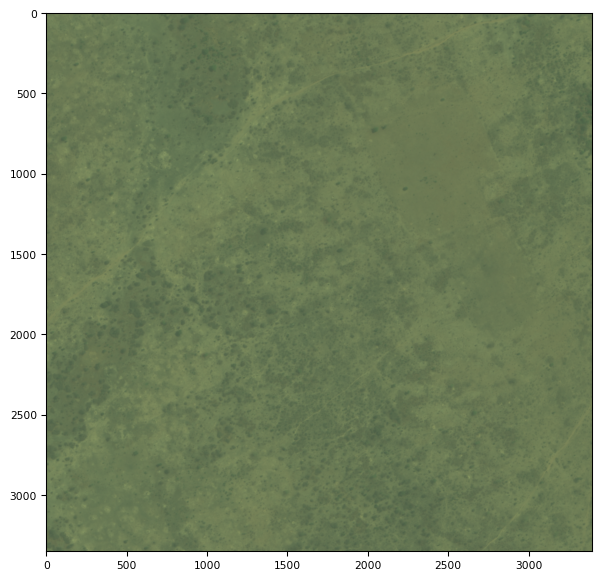

In [13]:
img_filename_3bandP = "../data/three_band/6010_0_0.tif"
P3 = tiff.imread(img_filename_3bandP) 
tiff.imshow(P3)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x128c3a1c0>)

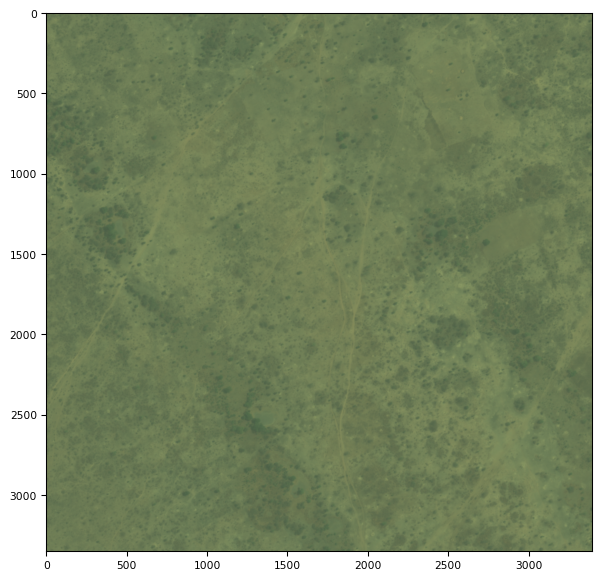

In [38]:
img_filename_3bandP = "../data/three_band/6010_0_1.tif"
P3 = tiff.imread(img_filename_3bandP) 
tiff.imshow(P3)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x128c00e80>)

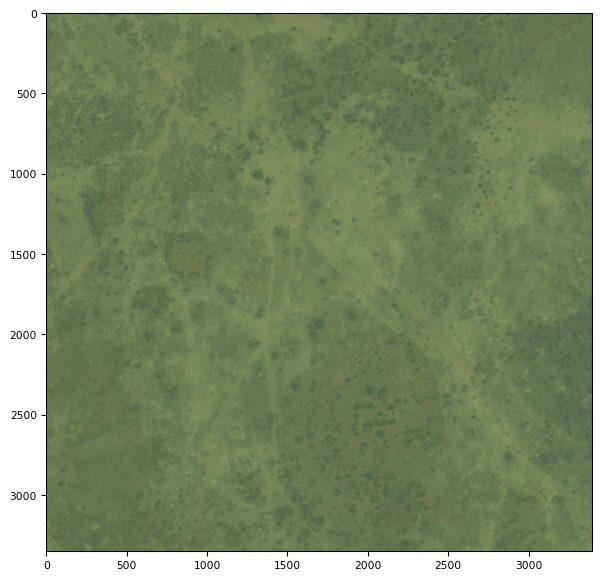

In [39]:
img_filename_3bandP = "../data/three_band/6010_0_2.tif"
P3 = tiff.imread(img_filename_3bandP) 
tiff.imshow(P3)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x128d12d60>)

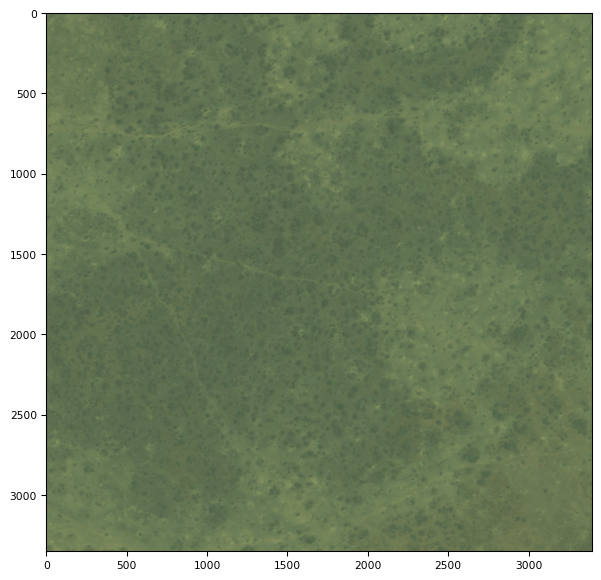

In [40]:
img_filename_3bandP = "../data/three_band/6010_0_3.tif"
P3 = tiff.imread(img_filename_3bandP) 
tiff.imshow(P3)

(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x12990efd0>)

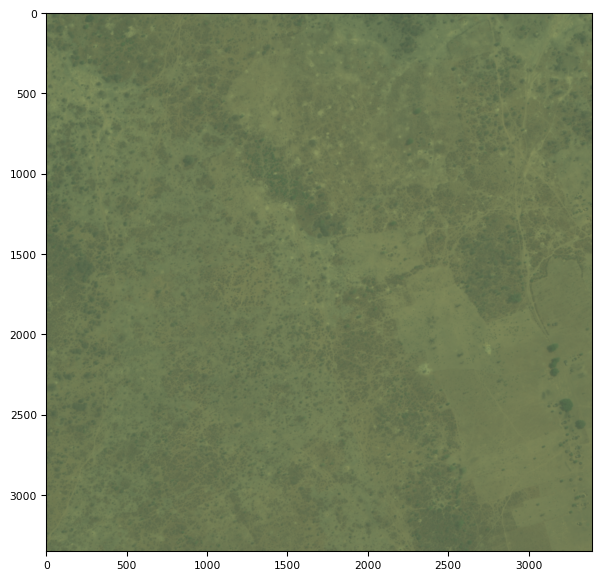

In [98]:
image_name = "6010_1_2.tif"
img_filename_3bandP = "../data/three_band/" + image_name
P3 = tiff.imread(img_filename_3bandP) 
tiff.imshow(P3)

- read in the sizes

In [79]:
 image_name.removesuffix(".tif")

'6010_0_4'

In [87]:
grid_sizes_df[grid_sizes_df.image_name == image_name.removesuffix(".tif")]

,image_name,Xmax,Ymin
107,6010_1_2,0.009169,-0.009042


-scale the image


In [88]:
channels, height, width = P3.shape

In [89]:
height

3349

In [90]:
width

3396

In [91]:
width1 = width * (width/ (width + 1))

In [92]:
width1

3395.000294377392

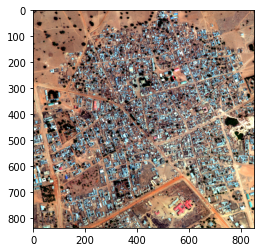

In [122]:

def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)    
    
def M(image_id):
    filename = os.path.join('..', 'data', 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)    
    img = np.rollaxis(img, 0, 3)
    return img

image_id = '6120_2_2'
m = M(image_id)
img = np.zeros((837,851,3))
img[:,:,0] = m[:,:,4] #red
img[:,:,1] = m[:,:,2] #green
img[:,:,2] = m[:,:,1] #blue
plt.imshow(stretch_8bit(img))
stretch_img = stretch_8bit(img)

- Get the objects

In [96]:
image_name.removesuffix('.tif')

'001_MM_L5_MISC_SMALL_STRUCTURE'

In [111]:
def coordi_to_raster(coords, img_size, xmax, ymax):
    """
    converts coordinates(polygons) to raster(pixels).
    """
  
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / xmax
    yf = H1 / ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [112]:
def convert_contours(polygonList, raster_img_size, xmax, ymax):
    """
    Returns exterior and interior coords of the given multipolygon,
    which are then used to create image masks with multipolygon objects.
    """
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = coordi_to_raster(perim, raster_img_size, xmax, ymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = coordi_to_raster(interior, raster_img_size, xmax, ymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

In [125]:

def generate_mask_for_image_and_class(raster_size, image_id, class_type, GS, TR):

    """
    returns generated image_mask using img_size(raster_size), image_id and class_type.
    """
    xmax, ymax = GS[GS.ImageId == image_id].iloc[0, 1:].astype(float)

    df_image = TR[TR.ImageId == image_id]
    multipoly_def = df_image[df_image.ClassType == class_type].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    
    contours = convert_contours(polygonList, raster_size, xmax, ymax)

    img_mask = np.zeros(raster_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, 1)
    cv2.fillPoly(img_mask, interior_list, 0)

    return img_mask

In [132]:
image_id = '6120_2_2'

mask = generate_mask_for_image_and_class( (stretch_img.shape[0], stretch_img.shape[1]) , image_id, 1,  GS=grid_sizes_df , TR=train_wkt_df)

/var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/ipykernel_41103/1640519105.py:10: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for k in range(len(polygonList)):
/var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/ipykernel_41103/1640519105.py:11: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  poly = polygonList[k]


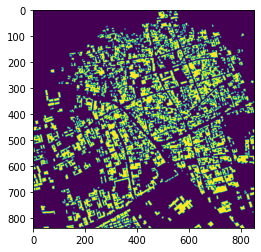

In [133]:
plt.imshow(mask)

### 16 bands

(<Figure size 988.8x604.8 with 3 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x1275616a0>)

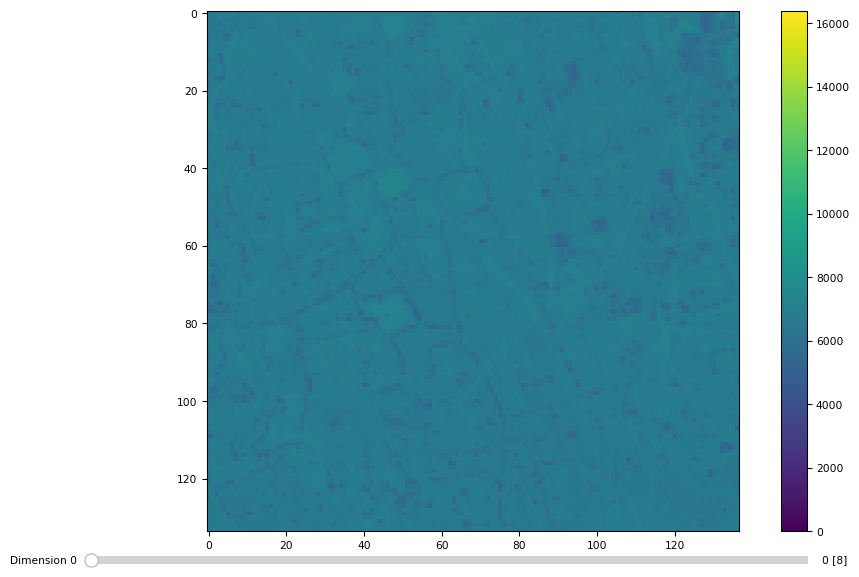

In [4]:
# 16 band 
image_16_name = "6120_0_1_A.tif"
img_filename_16bandP = "../data/sixteen_band/" + image_16_name
P16 = tiff.imread(img_filename_16bandP) 
tiff.imshow(P16)

In [5]:
P16.shape

(8, 134, 137)